   # Predict description of Python functions using Seq2Seq Model - 09/2019
Felix Le

## Overview

This project presents a simple sequence to sequence model which is used to predict the description (or summarization) of a Python function. The project is divided into three parts. The first section shows how we acquire and preprocess the input data. The second section demonstrates steps of building and training the seq2seq model. The final section evaluates the model's performance as well as suggests some approaches for improvement.

## Table of contents

* I. [Pre-process Data](#preprocess)  
    * 1. [Retrieve functions's code and docstring pairs from Python scripts](retrieve)
          * [Understand Python Docstrings](#understand)  
          * [Download and read raw python files](#download)  
          * [Parse data and tokenize](#parse)  
          * [Flatten code, docstring pairs and extract meta-data](#flatten)
          * [Remove Duplicates](#remove)
          * [Separate function without docstrings](#separate)
          * [Partition code by repository to train, valid and test sets](#partition)
          * [Output data in each set to .function/.docstring/.lineage files](#output)
    * 2. [Prepare data for training model](#prepare)
          * [Read Text From File](#read)
          * [Reduce the size of training dataset](#reduce)
          * [Tokenize Text](#tokenize)
          * [Save tokenized text](#save)
          * [Arrange data for modelling](#arrange)
          
* II. [Building and Training the Seq2Seq Model](#training)  
     * [Create Seq2Seq Model](#create)
     * [Train Seq2seq Model](#train)

* III. [Evaluate the model](#evaluate) 
     * [Calculate BLEU score on test set](#calculate)
     * [Preview some predicted output vs original output](#preview)
     * [Save model on disk](#save_model)
     * [Suggestions for improvement](#suggestion)
     

# I. Pre-process Data <a name="preprocess"></a>

## 1. Retrieve functions's code and docstring pairs from Python scripts <a name="retrieve"></a>

### Understand Python Docstrings <a name="understand"></a>

Python Docstring is the documentation string which is written as a first statement in the function, method, class or module definition.They are a descriptive text written by a programmer mainly for themselves to know what the line of code or expression does. In fact, Docstrings are great sources of information for understanding the general purpose and functionality of the code rather than the comments which tends to focus on small steps. Therefore, they are definitely a useful source of data which can be used to train on the problem of predicting description of Python functions.

In the first section, we try to parse raw python files into function and docstring pairs, tokenize both function and docstring into tokens, and split these pairs into a train, valid and test set. Let's start by importing some necessary packages.

In [2]:
%load_ext autoreload
%autoreload 2

import ast
import glob
import re
from pathlib import Path
import astor
import pandas as pd
import spacy
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from data_utils import apply_parallel, flattenlist

EN = spacy.load('en')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Check version of Python
# @@@ Type ! to run a shell command in Python code chunk
! python -V

Python 3.6.9 :: Anaconda, Inc.


### Download and read raw python files <a name="download"></a>
The next thing we need to do is to gather python code. There is an open dataset that Google hosts on BigQuey that has Python code from open source projects on GitHub. Fortunately, the Google Kubeflow team have hosted the raw data in the form of 10 csv files, available at the url: https://storage.googleapis.com/kubeflow-examples/code_search/raw_data/00000000000{i}.csv . Let's save time by reading these csv files into a pandas dataframe, and parse out some meta data:

In [12]:
%%time 

df = pd.concat([pd.read_csv(f'https://storage.googleapis.com/kubeflow-examples/code_search/raw_data/00000000000{i}.csv')
             for i in range(10)])

# Split the column repo_path into 2 columns: nwo and path
df['nwo'] = df['repo_path'].apply(lambda r: r.split()[0])
df['path'] = df['repo_path'].apply(lambda r: r.split()[1])
df.drop(columns=['repo_path'], inplace=True)
df = df[['nwo', 'path', 'content']] # select interested columns only
df.head()

CPU times: user 47.2 s, sys: 22.7 s, total: 1min 9s
Wall time: 5min 57s


,nwo,path,content
0,fnl/libfnl,src/fnl/nlp/dictionary.py,"""""""\n.. py:module:: fnl.text.dictionary\n :s..."
1,KivApple/mcu-info-util,mcu_info_util/linker_script.py,from six import iteritems\n\n\ndef generate(op...
2,Yelp/pyleus,examples/bandwith_monitoring/bandwith_monitori...,"from __future__ import absolute_import, divisi..."
3,jhuapl-boss/boss-manage,bin/bearer_token.py,#!/usr/bin/env python3\n\n# Copyright 2016 The...
4,djfroofy/beatlounge,bl/orchestra/base.py,from itertools import cycle\n\nfrom twisted.py...


In [16]:
# Inspect shape of the raw data
df.shape

(1241664, 3)

The raw data contains approximately 1.2 million distinct python code files. We separate it into 3 columns, where the first column shows the name of repository, the second column shows the path to the script, and the third column contains the content of that Python script. 

### Parse data and tokenize <a name="parse"></a>

Our goal is to parse the python files into (code, docstrings) pairs. Fortunately, the standard library in python comes with the wonderful **ast** module which helps us extract function's code from files as well as extract docstrings.

We also use **astor** library to strip the code of comments by doing a round trip of converting the code to an AST and then from AST back to code.

In [17]:
def tokenize_docstring(text):
    "Apply tokenization using spacy to docstrings."
    tokens = EN.tokenizer(text)
    return [token.text.lower() for token in tokens if not token.is_space]

def tokenize_code(text):
    "A basic procedure for tokenizing code strings"
    return RegexpTokenizer(r'\w+').tokenize(text)

def get_function_docstring_pairs(blob):
    "Extract (function/method, docstring) pairs from a given code blob"
    pairs = []
    try:
        module = ast.parse(blob)
        classes = [node for node in module.body if isinstance(node, ast.ClassDef)]
        functions = [node for node in module.body if isinstance(node, ast.FunctionDef)]

        for _class in classes:
            functions.extend([node for node in _class.body if isinstance(node, ast.FunctionDef)])
            
        for f in functions:
            source = astor.to_source(f)
            docstring = ast.get_docstring(f) if ast.get_docstring(f) else ''
            function = source.replace(ast.get_docstring(f, clean=False), '') if docstring else source
            pairs.append((f.name, f.lineno, source, ' '.join(tokenize_code(function)),
                         ' '.join(tokenize_docstring(docstring.split('\n\n')[0]))
                         ))
    except (AssertionError, MemoryError, SyntaxError, UnicodeEncodeError): 
        pass
    return pairs
                
def get_function_docstrings_pair_list(blob_list):
    """Apply the function `get_function_docstring_pairs` on a list of blobs"""
    return [get_function_docstring_pairs(b) for b in blob_list]
            

The below function `apply_parallel` parses the code in parallel using process based threading. The number of `cpu_cores` can be adjusted according to system resources.

In [20]:
%%time
pairs = flattenlist(apply_parallel(get_function_docstrings_pair_list, df.content.tolist(), cpu_cores = 8))

CPU times: user 23.3 s, sys: 14.7 s, total: 38 s
Wall time: 19min 48s


Each element inside `pairs` is a list of tuple which contain the name of function, line number of source text, tokenization of code and tokenization of docstrings. If there is no docstring detected in the function, the docstring of that function will be represented as empty character ''. Below is an example of data contain inside an element of `pairs`:

**function name**: native  
**line number**: 50  
**docstring**: Decorator to be used as Debian native test fixture  
**code**: @classmethod  
def native(cls, dsc=DEFAULT_NATIVE, opts=None):  
    """"""  
    def wrapper(fn):  
        @wraps(fn)  
        def _native_repo(*args):  
            repo = cls.import_native(dsc, opts)  
            return fn(*args, repo=repo)  
        return _native_repo  
    return wrapper  
    
-------------------------------------------------------------------      

**function name**: _import_one  
**line number**: 94  
**docstring**:  
**code**: @classmethod  
def _import_one(cls, dsc, opts):  
    opts = opts or []  
    assert import_dsc(['arg0'] + opts + [dsc]) == 0  
    parsed = DscFile(dsc)  
    return ComponentTestGitRepository(parsed.pkg)  

-------------------------------------------------------------------  

**function name**: import_debian_tarball  
**line number**: 135  
**docstring**: Import a 3.0 (quilt) debian dir for overlay mode  
**code**: @classmethod  
def import_debian_tarball(cls, debian=DEFAULT_OVERLAY, opts=None):  
    """"""  
    repo = GitRepository.create(os.path.split('/')[-1].split('_')[0])  
    UnpackTarArchive(debian, repo.path)()  
    repo.add_files('.')  
    repo.commit_files('.', msg='debian dir')  
    expected_branches = ['master']  
    ComponentTestBase._check_repo_state(repo, 'master', expected_branches)  
    eq_(len(repo.get_commits()), 1)  
    os.chdir(repo.path)  
    return repo  


In [26]:
# Preview data inside df afer parsed out
assert len(pairs) == df.shape[0], f'Row count mismatch. `df` has {df.shape[0]:,} rows; \
`pairs` has {len(pairs):,} rows.'
df['pairs'] = pairs
df.head()

,nwo,path,content,pairs
0,fnl/libfnl,src/fnl/nlp/dictionary.py,"""""""\n.. py:module:: fnl.text.dictionary\n :s...","[(__init__, 19, def __init__(self, *leafs, **e..."
1,KivApple/mcu-info-util,mcu_info_util/linker_script.py,from six import iteritems\n\n\ndef generate(op...,"[(generate, 4, def generate(options, filename=..."
2,Yelp/pyleus,examples/bandwith_monitoring/bandwith_monitori...,"from __future__ import absolute_import, divisi...","[(__init__, 18, def __init__(self, size):\n ..."
3,jhuapl-boss/boss-manage,bin/bearer_token.py,#!/usr/bin/env python3\n\n# Copyright 2016 The...,"[(request, 46, def request(url, params=None, h..."
4,djfroofy/beatlounge,bl/orchestra/base.py,from itertools import cycle\n\nfrom twisted.py...,"[(schedule, 149, def schedule(time, func, args..."


### Flatten code, docstring pairs and extract meta-data <a name="flatten"></a>
Flatten (code, docstring) pairs

In [34]:
%%time
# flatten pairs
df = df.set_index(['nwo', 'path'])['pairs'].apply(pd.Series).stack() 
df = df.reset_index()
df.columns = ['nwo', 'path', '_', 'pair'] # column 3 contain level info

CPU times: user 5min 23s, sys: 31.2 s, total: 5min 54s
Wall time: 21min 41s


Extract meta-data and format dataframe:

In [72]:
%%time
df['function_name'] = df['pair'].apply(lambda p: p[0])
df['lineno'] = df['pair'].apply(lambda p: p[1])
df['original_function'] = df['pair'].apply(lambda p: p[2])
df['function_tokens'] = df['pair'].apply(lambda p: p[3])
df['docstring_tokens'] = df['pair'].apply(lambda p: p[4])
df = df[['nwo', 'path', 'function_name','lineno', 'original_function', 'function_tokens', 'docstring_tokens']]
# Add the column which contain info about github link to the python function
# A Git blob (binary large object) is the object type used to store the contents of each file in a repository.
df['url'] = df[['nwo', 'path', 'lineno']].apply(lambda x: 'https://github.com/{}/blob/master/{}#L{}'.\
                                                format(x[0], x[1], x[2]), axis=1)

df.head()

CPU times: user 3min 59s, sys: 19.8 s, total: 4min 19s
Wall time: 9min 52s


,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,fnl/libfnl,src/fnl/nlp/dictionary.py,__init__,19,"def __init__(self, *leafs, **edges):\n self...",def __init__ self leafs edges self edges edges...,,https://github.comfnl/libfnl/blob/master/src/f...
1,fnl/libfnl,src/fnl/nlp/dictionary.py,__eq__,23,"def __eq__(self, other):\n if isinstance(ot...",def __eq__ self other if isinstance other Node...,,https://github.comfnl/libfnl/blob/master/src/f...
2,fnl/libfnl,src/fnl/nlp/dictionary.py,__repr__,29,def __repr__(self):\n return 'Node<leafs={}...,def __repr__ self return Node leafs edges form...,,https://github.comfnl/libfnl/blob/master/src/f...
3,fnl/libfnl,src/fnl/nlp/dictionary.py,createOrGet,32,"def createOrGet(self, token):\n """"""\n\t\tCr...",def createOrGet self token if token in self ed...,create or get the node pointed to by ` token `...,https://github.comfnl/libfnl/blob/master/src/f...
4,fnl/libfnl,src/fnl/nlp/dictionary.py,setLeaf,47,"def setLeaf(self, key, order):\n """"""\n\t\tS...",def setLeaf self key order self leafs append o...,store the ` key ` as a leaf of this node at po...,https://github.comfnl/libfnl/blob/master/src/f...


In [75]:
# preview data inside df
df.head()

CPU times: user 4min 3s, sys: 434 ms, total: 4min 4s
Wall time: 4min 5s


,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,fnl/libfnl,src/fnl/nlp/dictionary.py,__init__,19,"def __init__(self, *leafs, **edges):\n self...",def __init__ self leafs edges self edges edges...,,https://github.com/fnl/libfnl/blob/master/src/...
1,fnl/libfnl,src/fnl/nlp/dictionary.py,__eq__,23,"def __eq__(self, other):\n if isinstance(ot...",def __eq__ self other if isinstance other Node...,,https://github.com/fnl/libfnl/blob/master/src/...
2,fnl/libfnl,src/fnl/nlp/dictionary.py,__repr__,29,def __repr__(self):\n return 'Node<leafs={}...,def __repr__ self return Node leafs edges form...,,https://github.com/fnl/libfnl/blob/master/src/...
3,fnl/libfnl,src/fnl/nlp/dictionary.py,createOrGet,32,"def createOrGet(self, token):\n """"""\n\t\tCr...",def createOrGet self token if token in self ed...,create or get the node pointed to by ` token `...,https://github.com/fnl/libfnl/blob/master/src/...
4,fnl/libfnl,src/fnl/nlp/dictionary.py,setLeaf,47,"def setLeaf(self, key, order):\n """"""\n\t\tS...",def setLeaf self key order self leafs append o...,store the ` key ` as a leaf of this node at po...,https://github.com/fnl/libfnl/blob/master/src/...


### Remove Duplicates <a name="remove"></a>

Remove observations where the same function appears more than once

In [79]:
%%time
before_dedup = len(df)
df = df.drop_duplicates(['original_function', 'function_tokens'])
after_dedup = len(df)

print(f'Removed {before_dedup - after_dedup:,} duplicate rows')
print(f'Number of functions in df after remove duplicates: {df.shape[0]}')

Removed 1,199,426 duplicate rows
Number of functions in df after remove duplicates: 5413932
CPU times: user 19.2 s, sys: 352 ms, total: 19.5 s
Wall time: 33.2 s


### Separate function without docstrings <a name="separate"></a>
Extract the functions without docstring and keep them in a separated dataframe. Noted that docstring should contain at least 3 words in order to be considered as a valid docstring.

In [82]:
# function return length of list, if not a list then return 0
def listlen(x):
    if not isinstance(x, list):
        return 0
    return len(x)

# Separate functions w/o docstrings
with_docstrings = df[df.docstring_tokens.str.split().apply(listlen) >=3]
without_docstrings = df[df.docstring_tokens.str.split().apply(listlen) < 3]

print(f'Number of fucntions without docstrings: {without_docstrings.shape[0]}')
print(f'Number of functions with docstrings: {with_docstrings.shape[0]}')    

Number of fucntions without docstrings: 4008693
Number of functions with docstrings: 1405239


### Partition code by repository to train, valid and test sets <a name="partition"></a>

Each repository may have its' own coding style. Therefore we want to avoid having code from the same repository in the training set as well as in the validation and test set. This is done by grouping the functions with docstrings by their repository.

In [83]:
grouped = with_docstrings.groupby('nwo')

In [84]:
# Split the data into train and test set in which train set contain 87% of data
# random_state is the seed used by the random number generator
train, test = train_test_split(list(grouped), train_size = 0.87, shuffle=True, random_state=8801)

# Split the train set further into train and validation set in which train set contain 82% of data
train, valid = train_test_split(train, train_size=0.82, random_state=8801)

The train set is a list of tuple, where each tuple contains the repository name, and the data of functions inside that repository. We will convert them to dataframe as below:

In [95]:
# Convert train, valid, test setfrom list to dataframe
train = pd.concat([d for _, d in train]).reset_index(drop=True) 
valid = pd.concat([d for _, d in valid]).reset_index(drop=True)
test = pd.concat([d for _, d in test]).reset_index(drop=True)

In [96]:
print(f'Number of rows in training set: {train.shape[0]}')
print(f'Number of rows in validation set: {valid.shape[0]}')
print(f'Number of rows in test set: {test.shape[0]}')
print(f'Without docstring rows: {without_docstrings.shape[0]}')


Number of rows in training set: 985811
Number of rows in validation set: 236102
Number of rows in test set: 183326
Without docstring rows: 4008693


Preview what the training set looks like. The functions token and docstring tokens are input to the models. The other information is important for diagnostics and reference later.

In [97]:
train.head()

,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,jkahn/samyro,samyro/integerize.py,reshape_cleavable,23,"def reshape_cleavable(tensor, per_example_leng...",def reshape_cleavable tensor per_example_lengt...,reshapes input so that it is appropriate for s...,https://github.com/jkahn/samyro/blob/master/sa...
1,jkahn/samyro,samyro/write.py,write,14,"def write(input_placeholder, output_activation...",def write input_placeholder output_activations...,samples from the model,https://github.com/jkahn/samyro/blob/master/sa...
2,jkahn/samyro,samyro/read.py,to_numpy_batch,23,"@classmethod\ndef to_numpy_batch(cls, batch, d...",classmethod def to_numpy_batch cls batch dtype...,takes an iterable of sample objects ; produces...,https://github.com/jkahn/samyro/blob/master/sa...
3,jkahn/samyro,samyro/read.py,to_numpy_arrays,33,"def to_numpy_arrays(self, dtype=numpy.int32):\...",def to_numpy_arrays self dtype numpy int32 ret...,returns numpy - ified version of string inputs...,https://github.com/jkahn/samyro/blob/master/sa...
4,jkahn/samyro,samyro/read.py,__init__,112,"def __init__(self, sample_length, batch_size, ...",def __init__ self sample_length batch_size enc...,provide one of filenames or filehandles .,https://github.com/jkahn/samyro/blob/master/sa...


### Output data in each set to .function/.docstring/.lineage files <a name="output"></a>

The data in each train/valid/test set are written to files in the root of the `./data/processed_data` as following:

   1.*{train/valid/test.function}* - these are python function definitions tokenized (by space), 1 line per function.  
   2.*{train/valid/test.docstring}* - these are docstrings that correspond to each of the python function definitions, and have a 1:1 correspondence with the lines in *.function files.  
   3.*{train/valid/test.lineage}* - every line in this file contains a link back to the original location (github repo link) where the code was retrieved. There is a 1:1 correspondence with the lines in this file and the other two files. This is useful for debugging.

Original functions are written to compressed `json` files. (Raw functions contain ,.\t \n etc... It is less error-prone using json format)


In [102]:
def write_to(df, filename, path='./data/processed_data/'):
    """
    Helper function to write processed files to disk
    """
    out = Path(path)
    out.mkdir(parents=True, exist_ok=True)
    df.function_tokens.to_csv(out/'{}.function'.format(filename), index=False)
    df.original_function.to_json(out/'{}_original_function.json.gz'.format(filename),\
                                  orient='values', compression = 'gzip')
    if filename != 'without_docstrings':
        df.docstring_tokens.to_csv(out/'{}.docstring'.format(filename), index=False)
    df.url.to_csv(out/'{}.lineage'.format(filename), index=False)

In [103]:
# Write data to output files
write_to(train, 'train')
write_to(valid, 'valid')
write_to(test, 'test')
write_to(without_docstrings, 'without_docstrings')

/home/felix/anaconda3/envs/code_description/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys
/home/felix/anaconda3/envs/code_description/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()
/home/felix/anaconda3/envs/code_description/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to su

Check the files that have been written in the `processed_data` directory:

In [104]:
!ls -lah ./data/processed_data

total 2.6G
drwxrwxr-x 2 felix felix 4.0K Sep 13 15:17 .
drwxrwxr-x 3 felix felix 4.0K Sep 13 15:11 ..
-rw-rw-r-- 1 felix felix  13M Sep 13 15:14 test.docstring
-rw-rw-r-- 1 felix felix  57M Sep 13 15:14 test.function
-rw-rw-r-- 1 felix felix  16M Sep 13 15:14 test.lineage
-rw-rw-r-- 1 felix felix  26M Sep 13 15:14 test_original_function.json.gz
-rw-rw-r-- 1 felix felix  70M Sep 13 15:13 train.docstring
-rw-rw-r-- 1 felix felix 306M Sep 13 15:12 train.function
-rw-rw-r-- 1 felix felix  85M Sep 13 15:13 train.lineage
-rw-rw-r-- 1 felix felix 138M Sep 13 15:13 train_original_function.json.gz
-rw-rw-r-- 1 felix felix  19M Sep 13 15:14 valid.docstring
-rw-rw-r-- 1 felix felix  70M Sep 13 15:13 valid.function
-rw-rw-r-- 1 felix felix  22M Sep 13 15:14 valid.lineage
-rw-rw-r-- 1 felix felix  32M Sep 13 15:14 valid_original_function.json.gz
-rw-rw-r-- 1 felix felix 1.1G Sep 13 15:14 without_docstrings.function
-rw-rw-r-- 1 felix felix 345M Sep 13 15:17 without_docstrings.lineage
-rw-rw-r-- 1 f

## 2. Prepare data for training model <a name="prepare"></a>

After the pairs of functions and docstring have been extracted, they need to be further processed in order to feed into the training model session later.   

### Read Text From File <a name="read"></a>

In [1]:
from pathlib import Path
from data_utils import get_step2_prerequisite_files, read_training_files
from keras.utils import get_file
OUTPUT_PATH = Path('./data/seq2seq/')
OUTPUT_PATH.mkdir(exist_ok=True, parents=True)

Using TensorFlow backend.


In [2]:
# Provide the directory where the files are saved before
train_function, test_function, train_docstring, test_docstring = read_training_files('./data/processed_data/')

In [3]:
print(f'Number of functions-docstring pairs for training + validation input: {len(train_function)}')
print(f'Number of functions-docstring pairs for testing input: {len(test_docstring)}')

# Make sure code and comment files have the same length
assert len(train_function) == len(train_docstring)
assert len(test_function) == len(test_docstring)

Number of functions-docstring pairs for training + validation input: 1221913
Number of functions-docstring pairs for testing input: 183326


### Reduce the size of training dataset <a name="reduce"></a>

There are about 1,2 million rows in the training set. It would take around 10 hours to train this whole dataset for one epoch using 8 CPUs. Since the project is mainly for demonstration an approach to predict code description,  we will reduce the size of training set in order to shorten the running time

In [4]:
from math import floor
reduced_factor = 4
train_function_minimized = train_function[0:floor(len(train_function)/reduced_factor)]
train_docstring_minimized = train_docstring[0:floor(len(train_docstring)/reduced_factor)]

test_function_minimized = test_function[0:floor(len(test_function)/reduced_factor)]
test_docstring_minimized = test_docstring[0:floor(len(test_docstring)/reduced_factor)]


print(f'Number of functions-docstring pairs for training + validation input after minimized: {len(train_function_minimized)}')
print(f'Number of functions-docstring pairs for testing input after minimized: {len(test_docstring_minimized)}')

# Make sure code and comment files have the same length
assert len(train_function_minimized) == len(train_docstring_minimized)
assert len(test_function_minimized) == len(test_docstring_minimized)

Number of functions-docstring pairs for training + validation input after minimized: 305478
Number of functions-docstring pairs for testing input after minimized: 45831


### Tokenize Text <a name="tokenize"></a>
In this step, we are going to pre-process the raw text for modelling. Specifically, we will clean, tokenize, apply padding or truncation to the training data by leveraging `processor` class from `ktext` library. This library is useful because it performs text processing using process-based threading in parallel, which helps to save a significant amount of running time.

You can find more information about `ktext` in this [link](https://github.com/hamelsmu/ktext). Below is a short introduction about utility functions offered by this library:


 **Utilities for pre-processing text for deep learning in Keras.**

`ktext` performs common pre-processing steps associated with deep learning (cleaning, tokenization, padding, truncation). Most importantly, `ktext` allows you to perform these steps using process-based threading in parallel. If you don't think you might benefit from parallelization, consider using the text preprocessing utilities in keras instead.

`ktext` helps you with the following:

1. **Cleaning** You may want to clean your data to remove items like phone numbers and email addresses and replace them with generic tags, or remove HTML. This step is optional, but can help remove noise in your data.

2. **Tokenization** Take a raw string, ex "Hello World!" and tokenize it so it looks like ['Hello', 'World', '!']

3. **Generating Vocabulary and a {Token -> index} mapping** Map each unique token in your corpus to an integer value. This usually stored as a dictionary. For example {'Hello': 2, 'World':3, '!':4} might be a valid mapping from tokens to integers. You usually want to reserve an integer for rare or unseen words (ktext uses 1) and another integer for padding (ktext uses 0). You can set a threshold for rare words (see documentation).

4. **Truncating and Padding** While it is not necessary, it can be much easier if all your documents are the same length. The way we can accomplish this is through truncating and padding. For all documents below the desired length we can pad the document with 0's and documents above the desired length can be truncated. This utility allows you to build a histogram of your document lengths and choose a sensible document length for your corpus.

This utility accomplishes all of the above using process-based threading for speed. Sklearn style fit, transform, and fit_transform interfaces are provided.

In [5]:
%%time
from ktext.preprocess import processor

# clean, tokenize, and apply padding to traing data
function_proc = processor(heuristic_pct_padding=.7, keep_n=20000)
t_function = function_proc.fit_transform(train_function_minimized)

# append_indicators = True appends the tokens '_start_' and '_end_' to each document
docstring_proc = processor(append_indicators=True, heuristic_pct_padding=0.7, keep_n=14000, padding='post')
t_docstring = docstring_proc.fit_transform(train_docstring_minimized)


 See full histogram by insepecting the `document_length_stats` attribute.
 See full histogram by insepecting the `document_length_stats` attribute.


CPU times: user 29.1 s, sys: 1.21 s, total: 30.3 s
Wall time: 1min 25s


### Save tokenized text <a name="save"></a>

In [6]:
import dill as dpickle
import numpy as np

# Save the processor
with open(OUTPUT_PATH/'py_function_proc_v2.dpkl', 'wb') as f:
    dpickle.dump(function_proc, f)
with open(OUTPUT_PATH/'py_docstring_proc_v2.dpkl', 'wb') as f:
    dpickle.dump(docstring_proc, f)

# Save the processed data 
np.save(OUTPUT_PATH/'py_t_function_vecs_v2.npy', t_function)
np.save(OUTPUT_PATH/'py_t_docstring_vecs_v2.npy', t_docstring)     

### Arrange data for modelling <a name="arrange"></a>

In [7]:
from seq2seq_utils import load_decoder_inputs, load_encoder_inputs, load_text_processor

encoder_input_data, encoder_seq_len = load_encoder_inputs(OUTPUT_PATH/'py_t_function_vecs_v2.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs(OUTPUT_PATH/'py_t_docstring_vecs_v2.npy')

num_encoder_tokens, enc_pp = load_text_processor(OUTPUT_PATH/'py_function_proc_v2.dpkl')
num_decoder_tokens, dec_pp = load_text_processor(OUTPUT_PATH/'py_docstring_proc_v2.dpkl')

Shape of encoder input: (305478, 55)
Shape of decoder input: (305478, 14)
Shape of decoder target: (305478, 14)
Size of vocabulary for data/seq2seq/py_function_proc_v2.dpkl: 20,002
Size of vocabulary for data/seq2seq/py_docstring_proc_v2.dpkl: 14,002



# II. Training Model <a name="training"></a>

In this part, we build the seq2seq model and train it using the data which have been prepared in part I.

## Create Seq2Seq Model <a name="create"></a>

The convenience function `build_seq2seq_model` constructs the architecture for a sequence-to-sequence model.
In this project, we build a simple architecture with only one layer for the encoder and decoder. 

In [8]:
from seq2seq_utils import build_seq2seq_model

seq2seq_Model = build_seq2seq_model(word_emb_dim=800,
                                   hidden_state_dim=1000,
                                   encoder_seq_len=encoder_seq_len,
                                   num_encoder_tokens=num_encoder_tokens,
                                   num_decoder_tokens=num_decoder_tokens)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
seq2seq_Model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 800)    11201600    Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 55)           0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 800)    3200        Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

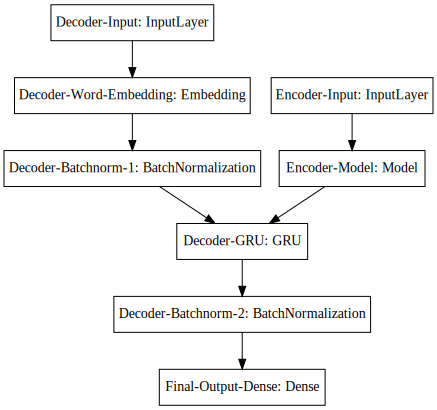

In [10]:
# View architecture of the model
from seq2seq_utils import viz_model_architecture
viz_model_architecture(seq2seq_Model)

## Train Seq2seq Model <a name="train"></a>

The model is trained with 4 epochs using 8 CPUs, which takes around 8 hours to complete. 

In [15]:
%%time

from keras.models import Model, load_model
import pandas as pd
import logging

from keras.callbacks import CSVLogger, ModelCheckpoint
import numpy as np
from keras import optimizers

seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.00005), loss='sparse_categorical_crossentropy')
script_name_base = 'py_func_sum_v9_'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                                                                           save_best_only=True)
batch_size = 1100
epochs = 4
history = seq2seq_Model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint]) 

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 268820 samples, validate on 36658 samples
Epoch 1/4
268820/268820 [==============================] - 6996s 26ms/step - loss: 5.0330 - val_loss: 4.0671


/home/felix/anaconda3/envs/code_description/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 1000) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/4
268820/268820 [==============================] - 7000s 26ms/step - loss: 3.8863 - val_loss: 3.8175
Epoch 3/4
268820/268820 [==============================] - 6957s 26ms/step - loss: 3.6533 - val_loss: 3.6546
Epoch 4/4
268820/268820 [==============================] - 6964s 26ms/step - loss: 3.4713 - val_loss: 3.5176
CPU times: user 23h 16min 57s, sys: 10min 9s, total: 23h 27min 6s
Wall time: 7h 45min 21s


# III. Evaluate Model <a name="evaluate"></a>

## Calculate BLEU score on test set <a name="calculate"></a>

In [23]:
# This will return a BLEU Score
seq2seq_inf.evaluate_model(input_strings=test_function_minimized, 
                           output_strings=test_docstring_minimized, 
                           max_len=None)

0.01936431480645111

## Preview some predicted output vs original output <a name="preview"></a>

The code below select randomly 15 examples and display their predicted values from the test set. In each example, *Original Input* is the function tokens, *Orignal Output* is the original docstring and *Predicted Output* is the predicted docstring

In [29]:
from seq2seq_utils import Seq2Seq_Inference
import pandas as pd 

seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=enc_pp,
                                       decoder_preprocessor=dec_pp,
                                       seq2seq_model=seq2seq_Model)

demo_testdf = pd.DataFrame({'code':test_function_minimized, 'comment':test_docstring_minimized, 'ref':''})
seq2seq_inf.demo_model_predictions(n=15, df=demo_testdf)



============== Example # 8103 =================

Original Input:
 def _test_path self path strings with app test_request_context login self app test example com test response self app get path follow_redirects True self assertEqual response status_code 200 for string in strings self assertIn string response data headers_keys key lower for key in response headers keys self assertIn etag headers_keys etag response headers get etag self assertNotEqual etag response self app get path headers If None Match etag follow_redirects True self assertEqual response status_code 304 self assertEqual response data
 

Original Output:
 helper function . test response for 200 status code . also test if response body contains event / service name .


****** Predicted Output ******:
 test that the user has a valid file


============== Example # 34713 =================

Original Input:
 def delete_permission self name currentsession None try if currentsession session currentsession else session self cr

## Save model on disk <a name="save_model"></a>

In [28]:
seq2seq_Model.save('./data/seq2seq/python_function_description_seq2seq_model.h5')

## Suggestions for improvement <a name="suggestion"></a>

As can be seen from the training session, the loss values have not reached the convergent point yet. The BLEU score is also less than 0.05 which indicates a poor performance of the model. Here are several approaches we can try to improve the model in the future:

**1. Use the complete training set**
Due to the computational limitation, we only use a quarter of the training set in this project. If more cores are provided and without time constraint, we can train this model on the complete dataset which contains about 1.2 million units. This method will definitely help to increase the accuracy of the model.

**2. Increase the number of epochs**
From the training output window, it can be seen that the loss values have reduced but not converged yet. We can train the model with a higher number of epochs to get a lower loss value. Of course, this will take more time to run the training session.

**3. Include the attention mechanism**
The model in this project uses a quite simple architecture with only one layer for the encoder and decoder. It can be improved by adding one more attention layer.